In [24]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
sys.path.append('../../Share/')
import baseline, config
import self_supervised_v1

import warnings
warnings.filterwarnings('ignore')

def plot_result(result):
    plt.figure(figsize=(10, 5))
    plt.plot(result.history['accuracy'], label='accuracy', marker='o')
    plt.plot(result.history['val_accuracy'], label='val_accuracy', marker='o')
    plt.title('Pre-training Stage')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()



SUBJECT = "Brian"
trainer = baseline.ModelTrainer(config, subject=SUBJECT)
trainer_Carlson = baseline.ModelTrainer(config, subject="Carlson")
trainer_Harold = baseline.ModelTrainer(config, subject="Harold")
trainer_Hunmin = baseline.ModelTrainer(config, subject="Hunmin")
#trainer_Brian = baseline.ModelTrainer(config, subject="Brian")
trainer_Xianyu = baseline.ModelTrainer(config, subject="Xianyu")

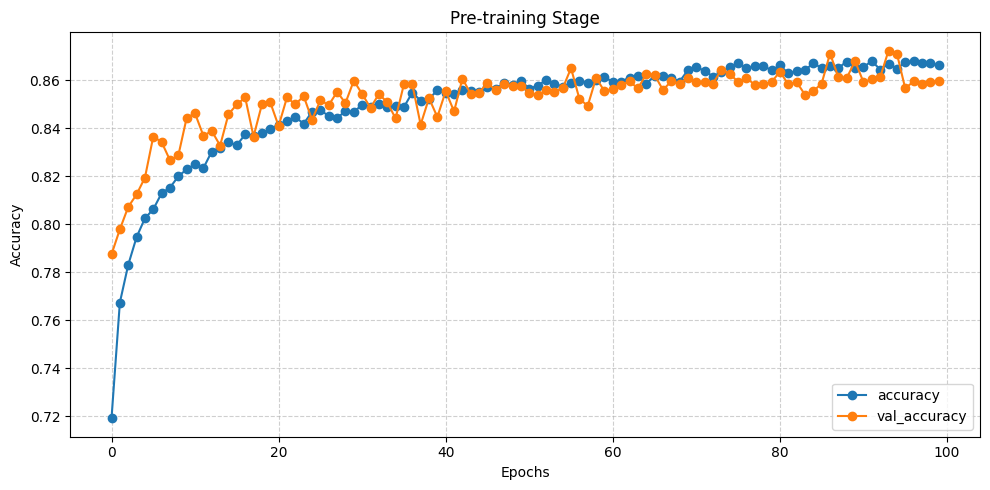

In [2]:
Threshold_K = 2  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
print(X_init.shape, y_init.shape, X_init_test.shape, y_init_test.shape)

model_K2 = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model_K2.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)

Dataset 1/14 - Session Exp_2025-06-27-v1/E9AD0E7DCC2B/
Dataset 2/14 - Session Exp_2025-06-27-v2/E9AD0E7DCC2B/
Dataset 3/14 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/14 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
(27563, 4, 14, 1) (27563,) (6890, 4, 14, 1) (6890,)


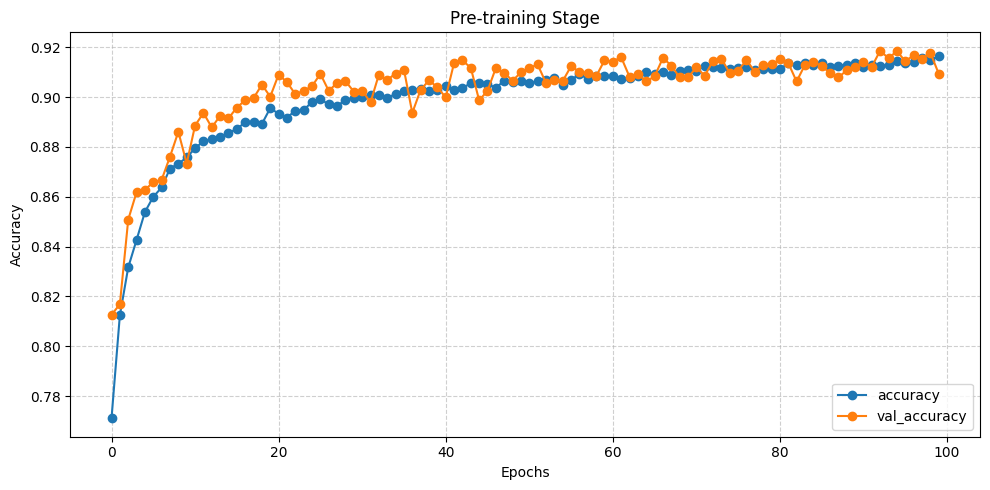

In [5]:
Threshold_K = 4  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
print(X_init.shape, y_init.shape, X_init_test.shape, y_init_test.shape)

model_K4 = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model_K4.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)

Dataset 1/14 - Session Exp_2025-06-27-v1/E9AD0E7DCC2B/
Dataset 2/14 - Session Exp_2025-06-27-v2/E9AD0E7DCC2B/
Dataset 3/14 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/14 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/14 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/14 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/


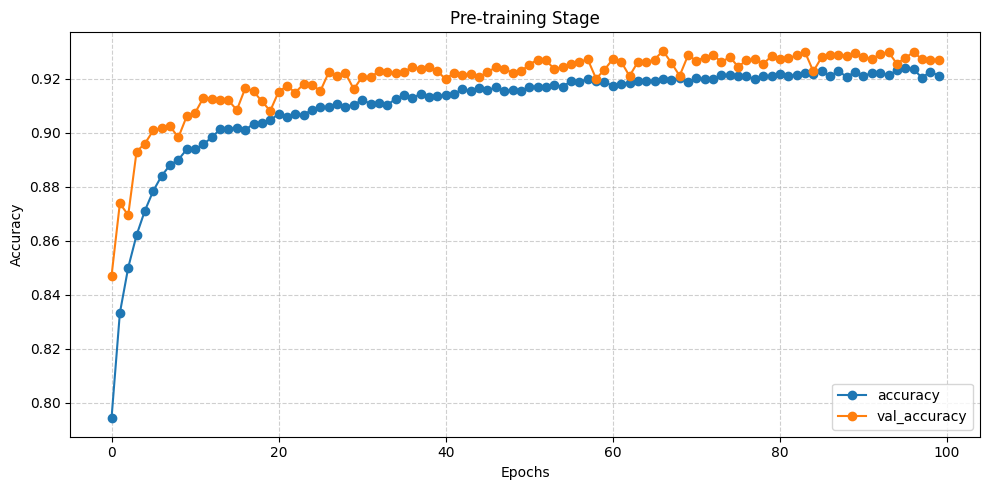

In [6]:
Threshold_K = 6  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model_K6 = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model_K6.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)

Dataset 1/14 - Session Exp_2025-06-27-v1/E9AD0E7DCC2B/


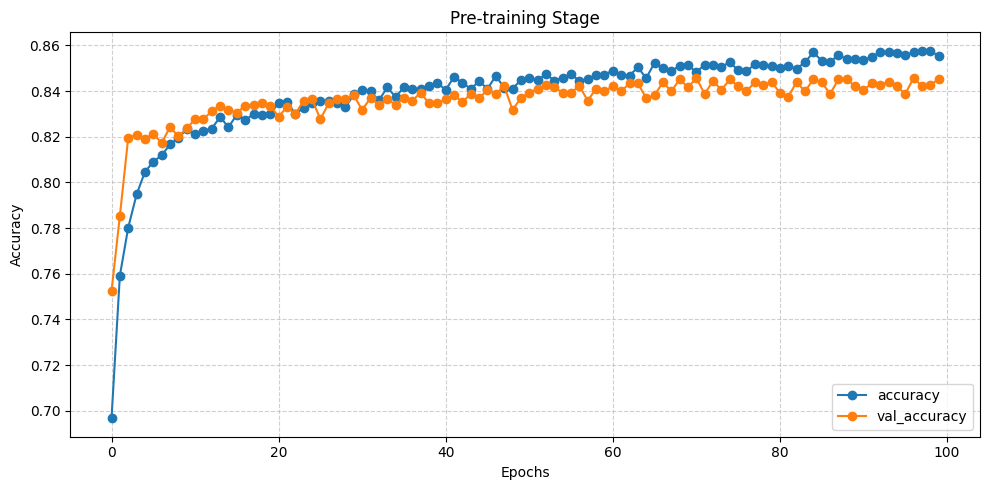

In [7]:
Threshold_K = 1  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model_K1 = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model_K1.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)

Dataset 1/14 - Session Exp_2025-06-27-v1/E9AD0E7DCC2B/
Dataset 2/14 - Session Exp_2025-06-27-v2/E9AD0E7DCC2B/
Dataset 3/14 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/14 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/14 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/14 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 7/14 - Session Exp_2025-07-16-v1/E9AD0E7DCC2B/
Dataset 8/14 - Session Exp_2025-07-16-v2/E9AD0E7DCC2B/


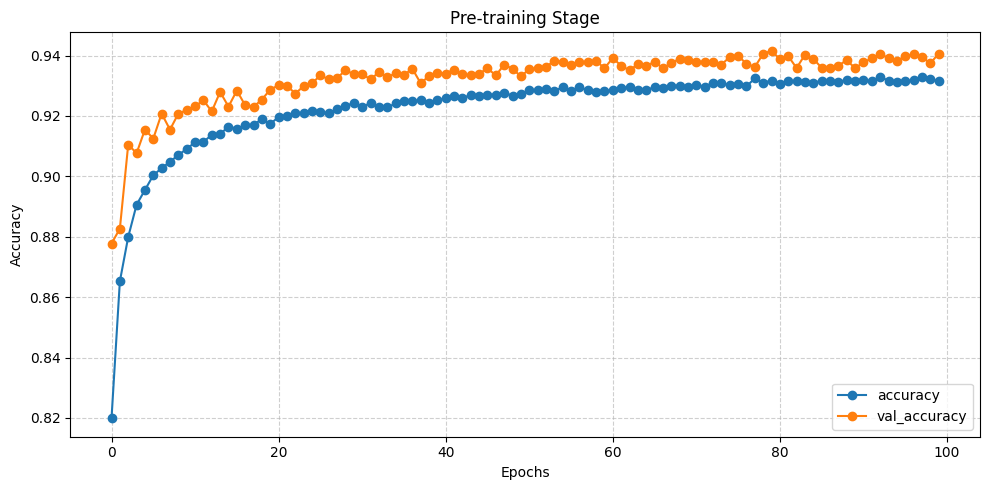

In [25]:
Threshold_K = 8  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model_K8 = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model_K8.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)

Dataset 1/14 - Session Exp_2025-06-27-v1/E9AD0E7DCC2B/
Dataset 2/14 - Session Exp_2025-06-27-v2/E9AD0E7DCC2B/
Dataset 3/14 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/14 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/14 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/14 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 7/14 - Session Exp_2025-07-16-v1/E9AD0E7DCC2B/
Dataset 8/14 - Session Exp_2025-07-16-v2/E9AD0E7DCC2B/
Dataset 9/14 - Session Exp_2025-07-17-v1/E9AD0E7DCC2B/
Dataset 10/14 - Session Exp_2025-07-17-v2/E9AD0E7DCC2B/


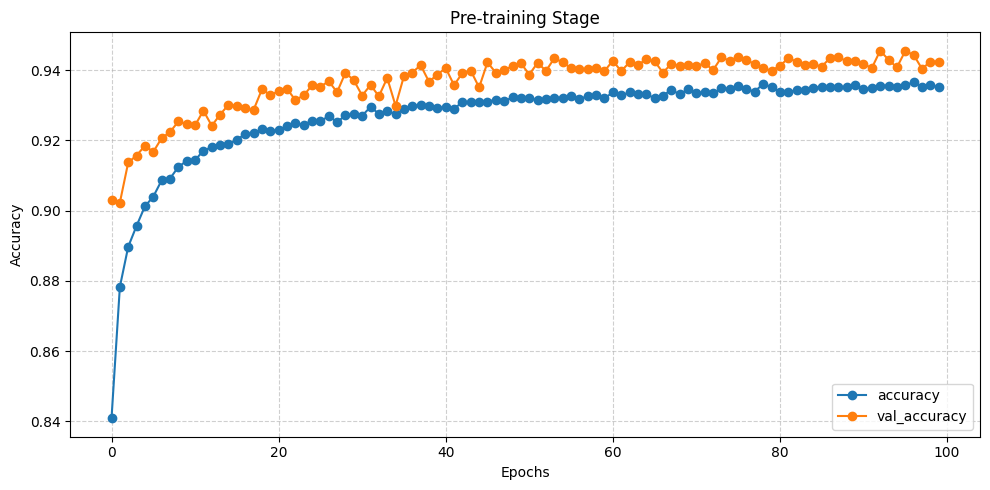

In [26]:
Threshold_K = 10  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model_K10 = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model_K10.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)

In [8]:
model = model_K6
Threshold_K=6

In [9]:
final_session = len(config.Info_sub_B)
# Accuracy 저장 리스트
Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"H": [], "C": [], "H2": [], "X": []}
trainers_unseen = {
    "H": trainer_Hunmin,
    "C": trainer_Carlson,
    "H2": trainer_Harold,
    #"B": trainer_Brian,
    "X": trainer_Xianyu,
}

def evaluate_model(model, data, labels):
    return model.evaluate(data, labels, verbose=0)[1]

# 온라인 학습 루프
for session in range(Threshold_K, final_session-1):
    # 현재 세션 데이터
    X_train, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)

    # Pseudo-label 생성 및 온라인 업데이트
    pseudo_labels = self_supervised_v1.generate_pseudo_label(model, X_train)
    model = self_supervised_v1.online_update(model, X_train, pseudo_labels)

    # 같은 세션 테스트
    Same_Session_Test_Acc.append(evaluate_model(model, X_test, y_test))

    # 다음 세션 테스트
    next_X, next_y, _, _ = trainer.return_K_th_data_only(K=session + 1, train_ratio=0.8)
    Next_Session_Test_Acc.append(evaluate_model(model, next_X, next_y))

    # Unseen subject 테스트
    for key, trainer_sub in trainers_unseen.items():
        unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=10, train_ratio=0.8)
        acc = evaluate_model(model, unseen_X, unseen_y)
        Unseen_subject_acc_dict[key].append(acc)

Returning K-th session data: Exp_2025-07-16-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-16-v2/E9AD0E7DCC2B/
Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/66 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/66 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/66 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/66 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 1/18 - Session Exp_2025-06-30-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-06-30-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dat

In [10]:
#K6
Same_Session_Test_Acc

[0.9329836964607239,
 0.9463667869567871,
 0.9331783652305603,
 0.9298143982887268,
 0.9229878187179565,
 0.9400465488433838,
 0.9473074674606323]

In [11]:
#K6
Next_Session_Test_Acc

[0.9442041516304016,
 0.922853410243988,
 0.930404543876648,
 0.9270516633987427,
 0.9285298585891724,
 0.9425303936004639,
 0.9285092949867249]

In [12]:
Threshold_K=4
model = model_K4

In [13]:
final_session = len(config.Info_sub_B)
# Accuracy 저장 리스트
Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"H": [], "C": [], "H2": [], "X": []}
trainers_unseen = {
    "H": trainer_Hunmin,
    "C": trainer_Carlson,
    "H2": trainer_Harold,
    #"B": trainer_Brian,
    "X": trainer_Xianyu,
}

def evaluate_model(model, data, labels):
    return model.evaluate(data, labels, verbose=0)[1]

# 온라인 학습 루프
for session in range(Threshold_K, final_session-1):
    # 현재 세션 데이터
    X_train, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)

    # Pseudo-label 생성 및 온라인 업데이트
    pseudo_labels = self_supervised_v1.generate_pseudo_label(model, X_train)
    model = self_supervised_v1.online_update(model, X_train, pseudo_labels)

    # 같은 세션 테스트
    Same_Session_Test_Acc.append(evaluate_model(model, X_test, y_test))

    # 다음 세션 테스트
    next_X, next_y, _, _ = trainer.return_K_th_data_only(K=session + 1, train_ratio=0.8)
    Next_Session_Test_Acc.append(evaluate_model(model, next_X, next_y))

    # Unseen subject 테스트
    for key, trainer_sub in trainers_unseen.items():
        unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=10, train_ratio=0.8)
        acc = evaluate_model(model, unseen_X, unseen_y)
        Unseen_subject_acc_dict[key].append(acc)

Returning K-th session data: Exp_2025-07-10-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/66 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/66 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/66 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/66 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 1/18 - Session Exp_2025-06-30-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-06-30-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dat

In [14]:
#K4
Same_Session_Test_Acc

[0.862048864364624,
 0.9042923450469971,
 0.8141025900840759,
 0.8321799039840698,
 0.834398627281189,
 0.9019721746444702,
 0.8147075772285461,
 0.8341094255447388,
 0.7938621640205383]

In [15]:
#K4
Next_Session_Test_Acc

[0.8899521827697754,
 0.8030015826225281,
 0.8406862616539001,
 0.8439633846282959,
 0.9051761627197266,
 0.8179186582565308,
 0.8454148769378662,
 0.8113781213760376,
 0.8355568647384644]

In [16]:
Threshold_K=2
model = model_K2

In [17]:
final_session = len(config.Info_sub_B)
# Accuracy 저장 리스트
Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"H": [], "C": [], "H2": [], "X": []}
trainers_unseen = {
    "H": trainer_Hunmin,
    "C": trainer_Carlson,
    "H2": trainer_Harold,
    #"B": trainer_Brian,
    "X": trainer_Xianyu,
}

def evaluate_model(model, data, labels):
    return model.evaluate(data, labels, verbose=0)[1]

# 온라인 학습 루프
for session in range(Threshold_K, final_session-1):
    # 현재 세션 데이터
    X_train, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)

    # Pseudo-label 생성 및 온라인 업데이트
    pseudo_labels = self_supervised_v1.generate_pseudo_label(model, X_train)
    model = self_supervised_v1.online_update(model, X_train, pseudo_labels)

    # 같은 세션 테스트
    Same_Session_Test_Acc.append(evaluate_model(model, X_test, y_test))

    # 다음 세션 테스트
    next_X, next_y, _, _ = trainer.return_K_th_data_only(K=session + 1, train_ratio=0.8)
    Next_Session_Test_Acc.append(evaluate_model(model, next_X, next_y))

    # Unseen subject 테스트
    for key, trainer_sub in trainers_unseen.items():
        unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=10, train_ratio=0.8)
        acc = evaluate_model(model, unseen_X, unseen_y)
        Unseen_subject_acc_dict[key].append(acc)

Returning K-th session data: Exp_2025-07-09-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/66 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/66 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/66 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/66 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 1/18 - Session Exp_2025-06-30-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-06-30-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dat

In [18]:
#K2
Same_Session_Test_Acc

[0.8258850574493408,
 0.7923433780670166,
 0.8492432832717896,
 0.846287727355957,
 0.806526780128479,
 0.8125720620155334,
 0.8471818566322327,
 0.8410673141479492,
 0.8181818127632141,
 0.828288733959198,
 0.820497989654541]

In [19]:
#K2
Next_Session_Test_Acc

[0.7936784029006958,
 0.8531936407089233,
 0.8444251418113708,
 0.8009616732597351,
 0.8145905137062073,
 0.8470143675804138,
 0.8389154672622681,
 0.8222607970237732,
 0.8257641792297363,
 0.8291835784912109,
 0.7975637912750244]

In [20]:
Threshold_K=1
model = model_K1

In [21]:
final_session = len(config.Info_sub_B)
# Accuracy 저장 리스트
Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"H": [], "C": [], "H2": [], "X": []}
trainers_unseen = {
    "H": trainer_Hunmin,
    "C": trainer_Carlson,
    "H2": trainer_Harold,
    #"B": trainer_Brian,
    "X": trainer_Xianyu,
}

def evaluate_model(model, data, labels):
    return model.evaluate(data, labels, verbose=0)[1]

# 온라인 학습 루프
for session in range(Threshold_K, final_session-1):
    # 현재 세션 데이터
    X_train, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)

    # Pseudo-label 생성 및 온라인 업데이트
    pseudo_labels = self_supervised_v1.generate_pseudo_label(model, X_train)
    model = self_supervised_v1.online_update(model, X_train, pseudo_labels)

    # 같은 세션 테스트
    Same_Session_Test_Acc.append(evaluate_model(model, X_test, y_test))

    # 다음 세션 테스트
    next_X, next_y, _, _ = trainer.return_K_th_data_only(K=session + 1, train_ratio=0.8)
    Next_Session_Test_Acc.append(evaluate_model(model, next_X, next_y))

    # Unseen subject 테스트
    for key, trainer_sub in trainers_unseen.items():
        unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=10, train_ratio=0.8)
        acc = evaluate_model(model, unseen_X, unseen_y)
        Unseen_subject_acc_dict[key].append(acc)

Returning K-th session data: Exp_2025-06-27-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/66 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/66 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/66 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/66 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 1/18 - Session Exp_2025-06-30-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-06-30-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dat

In [22]:
#K1
Same_Session_Test_Acc

[0.7894124388694763,
 0.8218224048614502,
 0.8016241192817688,
 0.8696158528327942,
 0.8741299510002136,
 0.8199300765991211,
 0.8321799039840698,
 0.8471818566322327,
 0.8549883961677551,
 0.8477128148078918,
 0.8445867300033569,
 0.8372901082038879]

In [23]:
#K1
Next_Session_Test_Acc

[0.8381201028823853,
 0.8073075413703918,
 0.8726902604103088,
 0.8657387495040894,
 0.8104327321052551,
 0.8343425393104553,
 0.8475955128669739,
 0.8526895642280579,
 0.8483138084411621,
 0.8445414900779724,
 0.8206427097320557,
 0.873404860496521]

In [27]:
Threshold_K=8
model = model_K8

final_session = len(config.Info_sub_B)
# Accuracy 저장 리스트
Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"H": [], "C": [], "H2": [], "X": []}
trainers_unseen = {
    "H": trainer_Hunmin,
    "C": trainer_Carlson,
    "H2": trainer_Harold,
    #"B": trainer_Brian,
    "X": trainer_Xianyu,
}

def evaluate_model(model, data, labels):
    return model.evaluate(data, labels, verbose=0)[1]

for session in range(Threshold_K, final_session-1):
    X_train, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)
    pseudo_labels = self_supervised_v1.generate_pseudo_label(model, X_train)
    model = self_supervised_v1.online_update(model, X_train, pseudo_labels)

    Same_Session_Test_Acc.append(evaluate_model(model, X_test, y_test))
    next_X, next_y, _, _ = trainer.return_K_th_data_only(K=session + 1, train_ratio=0.8)
    Next_Session_Test_Acc.append(evaluate_model(model, next_X, next_y))


Returning K-th session data: Exp_2025-07-17-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-17-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-17-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-24-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-24-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-24-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-24-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-08-01-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-08-01-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-08-01-v2/E9AD0E7DCC2B/


In [29]:
Same_Session_Test_Acc

[0.9174898266792297,
 0.9425753951072693,
 0.9420961141586304,
 0.9330617189407349,
 0.9554139971733093]

In [28]:
Next_Session_Test_Acc

[0.9347542524337769,
 0.93313068151474,
 0.9465793371200562,
 0.9530978798866272,
 0.9454756379127502]

In [30]:
Threshold_K=10
model = model_K10

final_session = len(config.Info_sub_B)
# Accuracy 저장 리스트
Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"H": [], "C": [], "H2": [], "X": []}
trainers_unseen = {
    "H": trainer_Hunmin,
    "C": trainer_Carlson,
    "H2": trainer_Harold,
    #"B": trainer_Brian,
    "X": trainer_Xianyu,
}

def evaluate_model(model, data, labels):
    return model.evaluate(data, labels, verbose=0)[1]

for session in range(Threshold_K, final_session-1):
    X_train, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)
    pseudo_labels = self_supervised_v1.generate_pseudo_label(model, X_train)
    model = self_supervised_v1.online_update(model, X_train, pseudo_labels)

    Same_Session_Test_Acc.append(evaluate_model(model, X_test, y_test))
    next_X, next_y, _, _ = trainer.return_K_th_data_only(K=session + 1, train_ratio=0.8)
    Next_Session_Test_Acc.append(evaluate_model(model, next_X, next_y))


Returning K-th session data: Exp_2025-07-24-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-24-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-24-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-08-01-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-08-01-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-08-01-v2/E9AD0E7DCC2B/


In [31]:
Same_Session_Test_Acc

[0.9583092331886292, 0.9412106871604919, 0.9565721154212952]

In [32]:
Next_Session_Test_Acc

[0.948326051235199, 0.9513607621192932, 0.9541763067245483]